# Performances on denoised images

Bertrand Thia (bt2513)

In this notebook, we are going to assess the performances of our improved baseline on the denoised images we constructed during the data preparation step. We will see the efficiency of this preprocessing. 

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, SeparableConv2D
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from keras.preprocessing import image

np.random.seed(0)

Using TensorFlow backend.


# Loading the data and data preprocessing

In [2]:
train_labels = pd.read_csv('../train.csv')

### Splitting into training set and validation set 

In [3]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

In [4]:
print('Train size: %d \t Validation size: %d' %(len(train_set), len(valid_set)))

Train size: 901 	 Validation size: 226


In [5]:
train_set['label'].value_counts()

normal       280
bacterial    280
viral        280
covid         61
Name: label, dtype: int64

### Standardization

We will apply our preprocessing on the denoised images now:

In [6]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  rotation_range= 20)

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

Let's use the same parameters as previously:

In [7]:
BATCH_SIZE = 32
W = 312
H = 251

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train2/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (W, H),
                                            batch_size= BATCH_SIZE, 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are first going to keep the same structure for our model since we want to compare the performances with the previous improved baseline model and a different preprocessing:

In [8]:
bas_model = Sequential()
bas_model.add(Conv2D(16, (3, 3), input_shape= (W, H, 1), activation= 'relu'))
bas_model.add(Conv2D(16, (3, 3), activation= 'relu'))
bas_model.add(MaxPooling2D(pool_size= (2, 2)))

bas_model.add(Conv2D(32, (3, 3), activation= 'relu'))
bas_model.add(Conv2D(32, (3, 3), activation= 'relu'))
bas_model.add(BatchNormalization())
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Dropout(0.2)) 

bas_model.add(Flatten())

bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 

bas_model.add(Dense(units= 64, activation= 'relu')) 
bas_model.add(Dropout(0.3)) 

bas_model.add(Dense(units= 4, activation= 'softmax'))

In [9]:
bas_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 310, 249, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 308, 247, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 154, 123, 16)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 152, 121, 32)      688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 150, 119, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 119, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 59, 32)       

In [10]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(lr= 1e-4), 
                 metrics = ['accuracy'])

### Training 

In [11]:
epochs= 70
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 3)
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

Since our dataset is imbalanced, we are going to use class weigthing to address the issue:

In [12]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [ ]:
hist = bas_model.fit_generator(X_train, 
                                steps_per_epoch= len(train_set) // BATCH_SIZE, 
                                epochs= epochs, 
                                verbose= 1, 
                                validation_data = X_val, 
                                validation_steps= len(valid_set) // BATCH_SIZE,
                                class_weight= class_weight,
                                callbacks= [checkpoint])

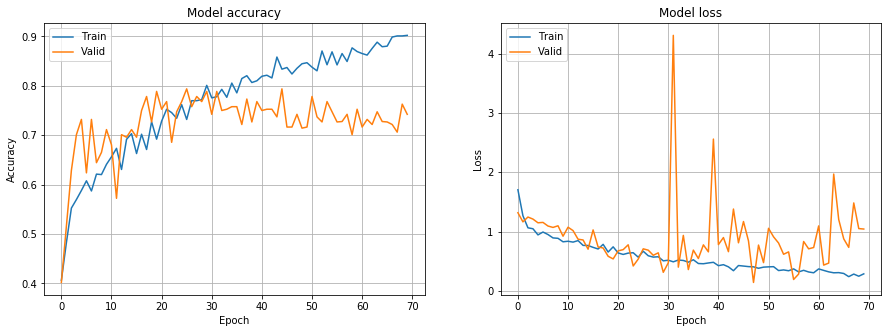

In [14]:
# Plotting the training curves

fig, axs = plt.subplots(1, 2, figsize= (15, 5))

# Plot training & validation accuracy values
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Valid'], loc='upper left')
axs[0].grid()

# Plot training & validation loss values
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(['Train', 'Valid'], loc='upper left')
plt.show()

### Evaluating our best model

In [19]:
# Loading the best weights
bas_model.load_weights("weights-improvement-21-0.75.hdf5")

In [20]:
evaluation = bas_model.evaluate_generator(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.792


In [21]:
# Loading the validation set manually to compare the results without the shuffling
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train2/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        color_mode= 'grayscale',
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [22]:
pred = bas_model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 0, 3, 2, 3, 3, 0, 0, 0])

In [23]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [24]:
y_val = valid_set['label'].map(X_val.class_indices).values

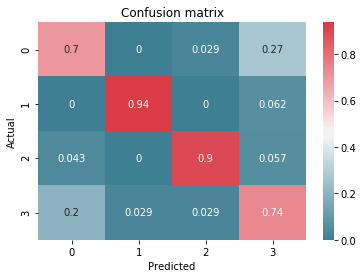

In [25]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'],
                               normalize= 'index')

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        70
           1       0.88      0.94      0.91        16
           2       0.94      0.90      0.92        70
           3       0.68      0.74      0.71        70

    accuracy                           0.79       226
   macro avg       0.81      0.82      0.82       226
weighted avg       0.80      0.79      0.79       226



**Finally, we can observe that the performances are quite similar as previously. Just denoising the images do not bring much improvement.**

---

# Appendix

### Plotting the accuracy with the evaluation method to choose the best weights

In [15]:
acc = []
epoch = []
path = '.'

weight_list = os.listdir(path)
for w in weight_list:
    split = w.split('-')
    if split[0] == 'weights':
        epoch.append(split[2])
        bas_model.load_weights(w)
        acc.append(bas_model.evaluate_generator(X_val))

In [16]:
epoch = [int(e) for e in epoch]
sorted_acc = [x for _,x in sorted(zip(epoch, acc))]

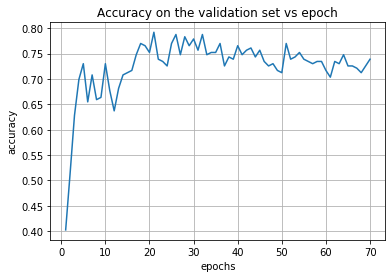

In [17]:
plt.plot(sorted(epoch), np.array(sorted_acc)[:, 1])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy on the validation set vs epoch')
plt.grid()
plt.show()

In [18]:
print('Best accuracy %.3f @ epoch %d' %(max(np.array(sorted_acc)[:, 1]), 
                                        sorted(epoch)[np.argmax(np.array(sorted_acc)[:, 1])]))

Best accuracy 0.792 @ epoch 21
